In [1]:
import classifiers.labeller as labeller
import classifiers.arima as arima
import nn_train_driver
import plotting.plot_shortcuts as ps
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Report

## The Why

Financial markets are complex beasts that require a specialized skill set to even begin to predict. If tis skill set was implemented in a machine learning model, then participating in financial markets could be more accessible to the general population. To solve this problem, we present four different models: `Multilayer Perceptron` (MLP), `Long Short-Term Memory` (LSTM), `Convolutional Neural Network` (CNN), and `Autoregressive Integated Moving Average` (ARIMA). In the code below, we explore the feasability of predicting market trends as increasing or decreasing with these four models.

## The What

### AI Techniques

The AI tecehniques applied in this notebook inolve preprocessing the data using Fourier Transforms to obtain a smooth market signal, fitting the previously mentioned models on that smoothed data, and forecasting future prices with the previously mentioned model. 

### Data Collection

The data used for this analysis was collected over the fiscal year 2022 for the market ticker QQQ. The data was collected from Yahoo! Finance and reflects the minute by minute price of QQQ over the entire year of 2022.

### Preprocessing Steps

Stock Market data is very noisy, and is often likened to "random walks". Because of this, computing outright price differentials (price_t - price_t-1) will not result in an accurate reflection of the asset price's true behavior. So, some form of "truth" data must be extracted from our noisy measurements.

In order to best classify the direction of the market's movement, the following process was conducted to compute "truth" data:

1. To account for overall growth/decay behavior, the coefficients of the following exponential function were optimized to the data:
$\newline$
$y = Ax^B + C$
$\newline$

2. To account for fluctuations around the exponential function, an FFT was computed on the following price values:
$\newline$
$clean\_signal = FFT(raw\_data - growth\_model)$
$\newline$

3. Produce a clean version of the market data:
$\newline$
$clean\_market\_signal = growth\_model + clean\_signal$
$\newline$

4. Compute Velocity of clean market data
$\newline$
$ velocity = \frac{\delta clean\_market\_signal}{\delta t}$
$\newline$

5. Compute Labels from Velocity
$\newline$
$ y = 0;\space velocity < 0 \newline$
$ y = 1;\space velocity > 0$

The resulting smoothed data from this process is shown below.

Computing Label Space...


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:06<00:00, 39.97it/s]

      EpochTime  Label  Label_Signal
0  1.641220e+09    1.0    400.260704
1  1.641220e+09    1.0    400.392394
2  1.641220e+09    1.0    400.475285
3  1.641220e+09    1.0    400.566385
4  1.641220e+09    1.0    400.664671


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

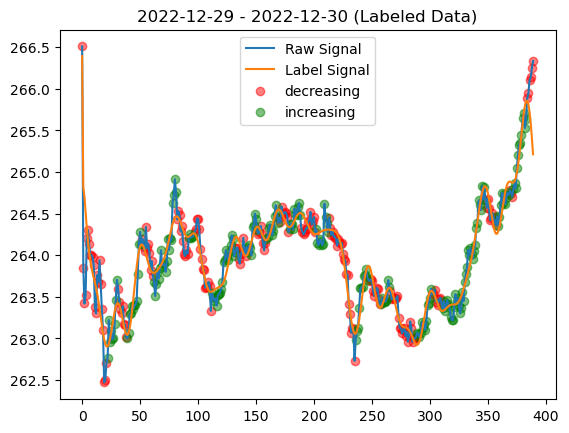

In [2]:
# read in data
data_df = pd.read_csv('./data/qqq_2022.csv')

# produce truth labels
print('Computing Label Space...')
label_df = labeller.driver(data_df, 18, 'Close')
print(label_df.head())

# plot data/labels/label signal
sig_col = 'Close'
forecast_sig_col = 'Forecast ' + sig_col
ps.plot_label_over_signal(data_df.iloc[-390:], label_df.iloc[-390:], sig_col, 'Labeled Data')

## The Who

As mentioned earlier, market data is noisy and analysis of it is complex. As a result, people may be intimidated by the market. For that reason, our project is aimed at new investors. This group of individulas may not have the background that a professional trader would. As such, they cna benefit from using algorithmic trading such as using machine learning models to forecast market prices.

## The How

For this inital experiment, we focused on predicting the minute by minute closing price of the ticker QQQ. To accomplish this, we focused on the timestamp of the price and the associated minute closing price. 

For our price movement classification models, we chose to use the `MLP`, `LSTM`, and `CNN` neural networks. As a baseline, we used `ARIMA` the differentials of the ARIMA forecast's values to compare against the 3 neural networks' performances. Generally speaking, `ARIMA` is an industry-standard model for forecasting data, with use cases outside of financial markets. 

### Labelling Explanation (Truth Data Extraction)

When it came time to train and evaluate the models, we first computed the increasing/decreasing binary label space for each temporal datapoint. Computing outright price differentials (price_t - price_t-1) on data that behaves similarly to random walks will not result in an accurate reflection of the asset price's true behavior. So, some form of "truth" data must be extracted from our noisy measurements.

In order to best classify the direction of the market's movement, the following process was conducted to compute "truth" data:

1. To account for overall growth/decay behavior, the coefficients of the following exponential function were optimized to the data:
$\newline$
$y = Ax^B + C$
$\newline$

2. To account for fluctuations around the exponential function, an FFT was computed on the following price values:
$\newline$
$clean\_signal = FFT(raw\_data - growth\_model)$
$\newline$

3. Produce a clean version of the market data:
$\newline$
$clean\_market\_signal = growth\_model + clean\_signal$
$\newline$

4. Compute Velocity of clean market data
$\newline$
$ velocity = \frac{\delta clean\_market\_signal}{\delta t}$
$\newline$

5. Compute Labels from Velocity
$\newline$
$ y = 0;\space velocity < 0 \newline$
$ y = 1;\space velocity > 0$


### Feature Space Computation (Neural Networks)

For the neural networks' feature space, we computed the time based differentials of a set of moving average lines across multiple periods (ranged 2-18, with a step of 2). We hoped this would provide a mix of short term and longer term trend behavior to for our models to learn.

We then piped these differentials through a tanh function, which scaled the data from (-1, 1) with a higher variance about 0 than standard min/max scaling can provide.

### Train/Test Split, Neural Network Fitting
Next, conducted a train/test split with a ratio of 0.8:0.2. 

### ARIMA
For ARIMA, we observed the partial-autocorrelation, autocorrelation, and difference plots in the market data to determine what order parameters to use. We then used a sliding window to fit the model, then forecasted the data one step into the future. Finally, we determined our "increase" and "decrease" classification based on the direction of the change from the forecast point.

### Analysis
Using the increasing/decreasing labels as our truth data, we assessed the 4 models based on their `confusion matrix`, `precision`, `recall`, `accuracy`, and `f1 score`. We sought to find models that maximized each of these assessment mechanisms.

In [3]:
# use the default config file for building/training the networks
nn_config = nn_train_driver.default_training_config()
print(f'Default Hyperparameter Configuration:')
pprint(nn_config)

# get the train/test data, onehot encode
train_df, test_df = nn_train_driver.split_data(data_df, label_df=label_df, config=nn_config)
train_label_onehot = nn_train_driver.convert_onehot(train_df.Label.values)
test_label_onehot = nn_train_driver.convert_onehot(test_df.Label.values)

Default Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}


## How Good

In the following sections, we train each model and compute their `precision`, `recall`, and `f1` metrics. 

### Multilayer Perceptron (MLP)


Training MLP:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,170 (4.57 KB)

 Trainable params: 1,170 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 843us/step - accuracy: 0.6834 - loss: 0.5957
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - accuracy: 0.6942 - loss: 0.5844
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.6938 - loss: 0.5840
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step

Test Space Classification Report (MLP):
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68      9207
         1.0       0.69      0.71      0.70      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

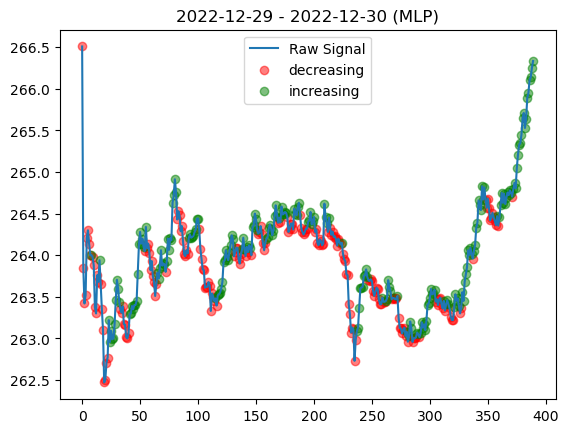

In [4]:
# build/train the MLP
print('\nTraining MLP:')
mlp = nn_train_driver.train_mlp(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# classify the test space, inverse onehot transform the data
yhat_test_mlp = nn_train_driver.inverse_onehot(mlp.predict(test_df[feature_cols]))

# get the properly formatted test space
ytrue_test_mlp = test_df['Label'].values

# print the classification report
mlp_class_rep = classification_report(ytrue_test_mlp, yhat_test_mlp)
print(f'\nTest Space Classification Report (MLP):\n{mlp_class_rep}')

# plot the MLP classifications on the last few days of data
yhat_test_mlp_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                                 'Label': yhat_test_mlp})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_mlp_df.iloc[-390:], 'Close', 'MLP')

### Long-Short Term Memory (LSTM)


Training LSTM:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 18, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,802 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6676 - loss: 0.6076
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6712 - loss: 0.5969
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6734 - loss: 0.5967
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   

Test Space Classification Report (LSTM):
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68      9207
         1.0       0.69      0.71      0.70      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

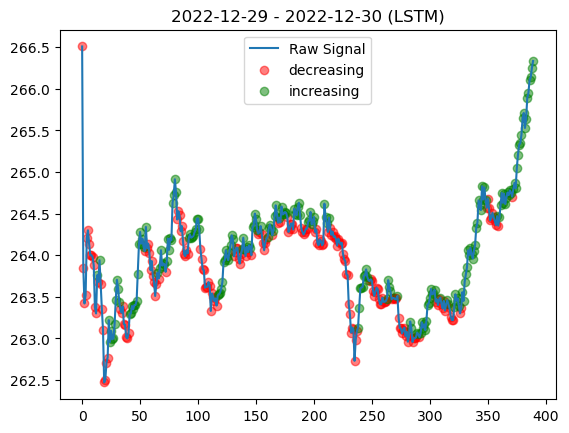

In [5]:
# build/train the LSTM
print('\nTraining LSTM:')
lstm = nn_train_driver.train_lstm(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# get the properly formatted test space
ytrue_test_lstm = test_df['Label']

# classify the test space/inverse onehot transform
yhat_test_lstm = nn_train_driver.inverse_onehot(lstm.predict(test_df[feature_cols]))

# print classification report
lstm_class_rep = classification_report(ytrue_test_lstm, yhat_test_lstm)
print(f'\nTest Space Classification Report (LSTM):\n{lstm_class_rep}')

# plot the LSTM classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test_lstm})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'LSTM')

### Convolutional Neural Network (CNN)


Training CNN:


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 100)             │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           2,802 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,402 (13.29 KB)

 Trainable params: 3,402 (13.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6490 - loss: 0.6336
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6782 - loss: 0.6048
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6750 - loss: 0.6088
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step

Test Space Classification Report (CNN):
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69      9348
         1.0       0.69      0.70      0.69      9445

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

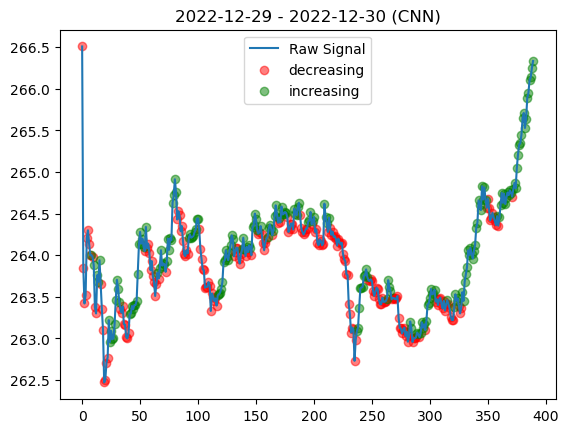

In [6]:
# build/train the CNN
print('\nTraining CNN:')
cnn = nn_train_driver.train_cnn(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# get the properly formatted test space
ytrue_test_cnn = test_df['Label'].values
yhat_test_cnn = nn_train_driver.inverse_onehot(cnn.predict(test_df[feature_cols]))
cnn_class_rep = classification_report(yhat_test_cnn, ytrue_test_cnn)
print(f'\nTest Space Classification Report (CNN):\n{cnn_class_rep}')

# plot the CNN classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test_cnn})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'CNN')

### ARIMA

#### Choosing ARIMA Order

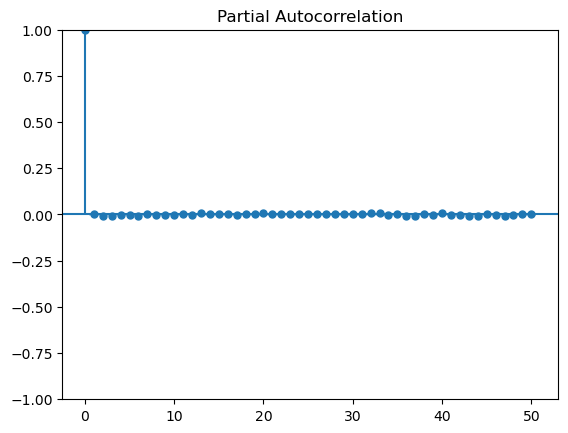

In [10]:
# The pacf and acf plots below are plotted twice due to an incompatability
# between the stats package and jupyter notebooks. Adding a semicolon to the
# end of the line solves the problem: https://github.com/statsmodels/statsmodels/issues/4155#issuecomment-445913264
plot_pacf(data_df[[sig_col]].diff().dropna());
p = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial autoregression param

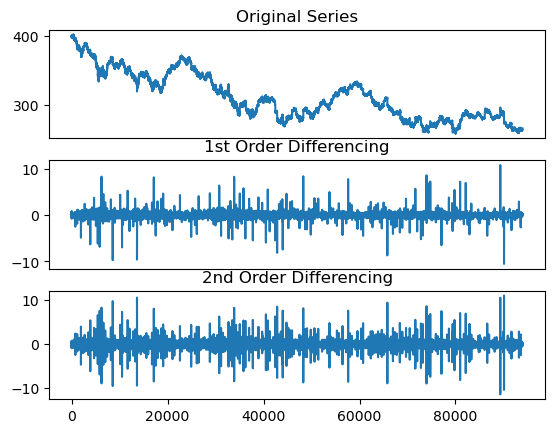

In [11]:
ps.plot_data_differencing(data_df, sig_col)
d = 1

Because the data appears relatively stabilized after a first order difference, we use that as the d param

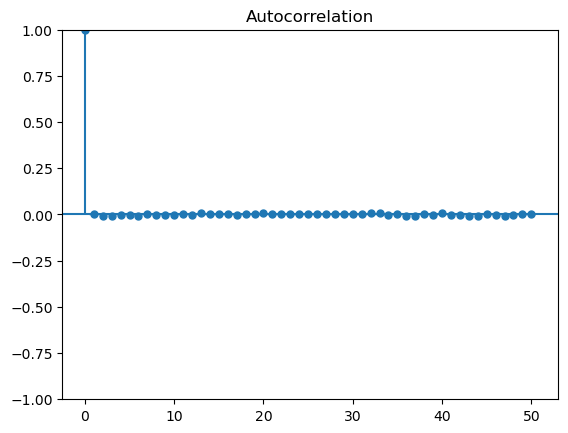

In [12]:
plot_acf(data_df[[sig_col]].diff().dropna());
q = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial moving average param

#### Evaluating ARIMA w/ Minute Forecasting

In [13]:
# filter data on the times from the test df above to cut down on run time.
# Running on the full "test_df" still takes about 15 mins
arima_minute_forecast_df = data_df.loc[np.in1d(data_df.EpochTime, test_df.EpochTime)]

# fit/forecast ARIMA
price_column = 'Close'
minute_forecast_df = arima.minute_forecast(arima_minute_forecast_df, sig_col=price_column)

100%|████████████████████████████████████████████████████████████████████████████| 18673/18673 [10:53<00:00, 28.58it/s]



ARIMA Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.59      0.58      9130
         1.0       0.60      0.59      0.59      9542

    accuracy                           0.59     18672
   macro avg       0.59      0.59      0.59     18672
weighted avg       0.59      0.59      0.59     18672



ARIMA Confusion Matrix:
[[5361 3769]
 [3911 5631]]


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

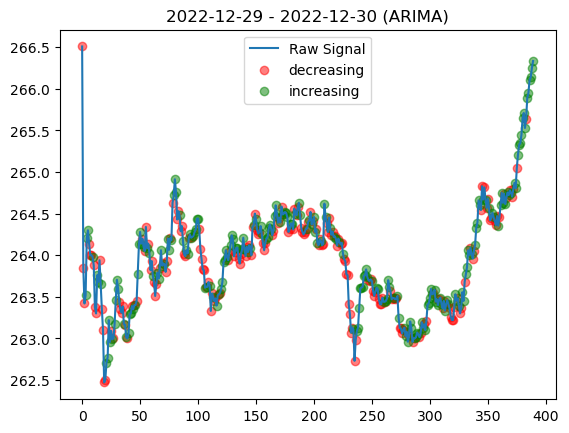

In [14]:
# classify the arima forecasts as increasing or decreasing
arima_yhat = arima.convert_forecast_to_classification(minute_forecast_df[f'Forecast {price_column}'].values)
arima_yhat_df = pd.DataFrame({'EpochTime': minute_forecast_df.EpochTime.iloc[-arima_yhat.shape[0]:],
                              'Label': arima_yhat})

# generate classification report
print(f'\nARIMA Classification Report:')
print(classification_report(test_df.Label.values[-arima_yhat.shape[0]:], 
                            arima_yhat))
print(f'\n\nARIMA Confusion Matrix:\n{confusion_matrix(test_df.Label.values[-arima_yhat.shape[0]:], arima_yhat)}')

# plot the ARIMA diff overtop the raw prices for the final day (390 minutes) in the DF
ps.plot_label_over_signal(data_df.iloc[-390:], arima_yhat_df.iloc[-390:], 'Close', model_type='ARIMA')

### Model Comparison

In [15]:
# print confusion matrices for each model
print(f'MLP Confusion Matrix:\n{confusion_matrix(ytrue_test_mlp, yhat_test_mlp)}')
print(f'\nMLP Test Space Classification Report:\n{classification_report(ytrue_test_mlp, yhat_test_mlp)}')

print(f'\n\nLSTM Confusion Matrix:\n{confusion_matrix(ytrue_test_lstm, yhat_test_lstm)}')
print(f'\nLSTM Test Space Classification Report:\n{classification_report(ytrue_test_lstm, yhat_test_lstm)}')

print(f'\n\nCNN Confusion Matrix:\n{confusion_matrix(ytrue_test_cnn, yhat_test_cnn)}')
print(f'\nCNN Test Space Classification Report:\n{classification_report(ytrue_test_cnn, yhat_test_cnn)}')

print(f'\n\nARIMA Confusion Matrix:\n{confusion_matrix(test_df.Label.values[-arima_yhat.shape[0]:], arima_yhat)}')
print(f'\nARIMA Classification Report:')
print(classification_report(test_df.Label.values[-arima_yhat.shape[0]:], 
                            arima_yhat))

MLP Confusion Matrix:
[[6150 3057]
 [2791 6795]]

MLP Test Space Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68      9207
         1.0       0.69      0.71      0.70      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



LSTM Confusion Matrix:
[[6173 3034]
 [2783 6803]]

LSTM Test Space Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68      9207
         1.0       0.69      0.71      0.70      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



CNN Confusion Matrix:
[[6370 2837]
 [2978 6608]]

CNN Test Space Classification Report:
              precision    recall  f1-score   support

         0.0       0.

Given that this experiment utilizes market data, we want a model that has a good balance of both the `precision` (true positive classification assessment), and `recall` (combined true and false positive classification assessment) metrics. To achieve this, we can look at the `f1 score` which combines both `precision` and `recall`. 

Given this criteria, the LSTM was the highest performing model according to the `f1 score`. The MLP was second, the CNN was third, and the ARIMA model was fourth. The difference in performance of these mdoels is particularly noticable in the tail end of the plot where the price has an increasing trend. The LSTM has the most accurate predictions here while the other models have more and more incorrect predictions. 

It is also worth nothing that even though the CNN was not the most performant model, it was particularly good at predicting when the price was increasing as seen through the `recall` metrics and the confusion matrix. 

## The Where

This code is not deployed anywhere. It is only contained in this notebook.

## Experiences

This was a fun and exciting project that put what we learning in the course to the test. We worked with signal smoothing, new and complex models, and a large amount of data. In terms of what could be improved, each model is relatively simple at the current state. They largely consist of three layers: input, flatten (where appropriate) and output. Given that both LSTM and CNN models allow for 2D data inputs, we can slice/stack the historical data to fully utilize the complexity of higher dimensional models. Additionally, there are most likely combinations of hyper-paramters that may be better suited for this data. 

Regarding future expansions on this work, we can look at using grid search to iterate over *every* possible combination of hyper-parameters of a given set and find the best ones. It would also be interesting to observe how the forecasts change when other signals are included such as overall market sentinment, sector sentiment, etc. 

# Standalone Code

In [1]:
import classifiers.labeller as labeller
import classifiers.arima as arima
import nn_train_driver
import plotting.plot_shortcuts as ps
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Computing Label Space...


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:06<00:00, 38.45it/s]

      EpochTime  Label  Label_Signal
0  1.641220e+09    1.0    400.260704
1  1.641220e+09    1.0    400.392394
2  1.641220e+09    1.0    400.475285
3  1.641220e+09    1.0    400.566385
4  1.641220e+09    1.0    400.664671


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

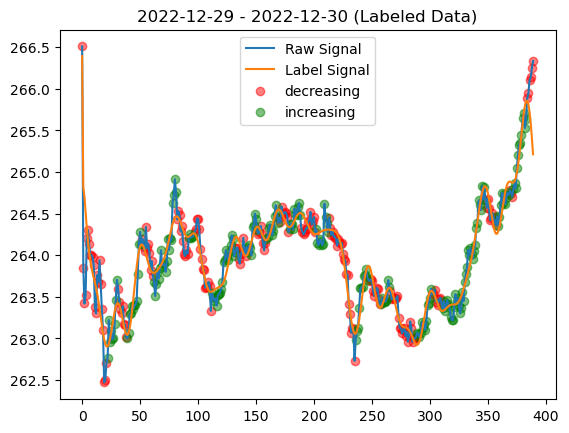

In [2]:
# read in data
data_df = pd.read_csv('./data/qqq_2022.csv')

# produce truth labels
print('Computing Label Space...')
label_df = labeller.driver(data_df, 18, 'Close')
print(label_df.head())

# plot data/labels/label signal
sig_col = 'Close'
forecast_sig_col = 'Forecast ' + sig_col
ps.plot_label_over_signal(data_df.iloc[-390:], label_df.iloc[-390:], sig_col, 'Labeled Data')

## Neural Net Assessments

### Conduct Preprocessing on Train/Test Data

In [3]:
# use the default config file for building/training the networks
nn_config = nn_train_driver.default_training_config()
print(f'Default Hyperparameter Configuration:')
pprint(nn_config)

# get the train/test data, onehot encode
train_df, test_df = nn_train_driver.split_data(data_df, label_df=label_df, config=nn_config)
train_label_onehot = nn_train_driver.convert_onehot(train_df.Label.values)
test_label_onehot = nn_train_driver.convert_onehot(test_df.Label.values)

Default Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}


### MLP


Training MLP:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 32)                  │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,170 (4.57 KB)

 Trainable params: 1,170 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step - accuracy: 0.6773 - loss: 0.5983
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 2s 787us/step - accuracy: 0.6927 - loss: 0.5850
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 2s 777us/step - accuracy: 0.6907 - loss: 0.5862
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

Test Space Classification Report (MLP):
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67      9207
         1.0       0.69      0.72      0.70      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

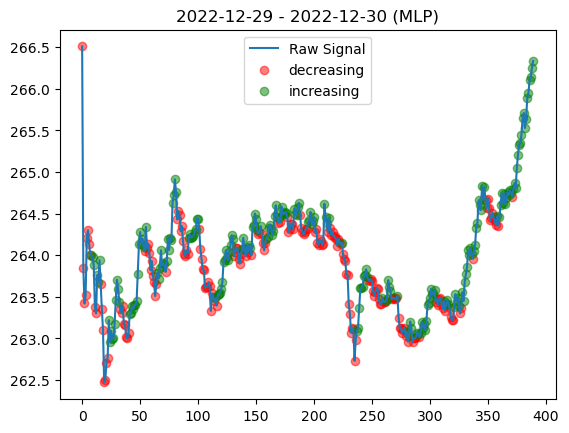

In [7]:
# build/train the MLP
print('\nTraining MLP:')
mlp = nn_train_driver.train_mlp(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# classify the test space, inverse onehot transform the data
yhat_test_mlp = nn_train_driver.inverse_onehot(mlp.predict(test_df[feature_cols]))

# get the properly formatted test space
ytrue_test_mlp = test_df['Label'].values

# print the classification report
mlp_class_rep = classification_report(ytrue_test_mlp, yhat_test_mlp)
print(f'\nTest Space Classification Report (MLP):\n{mlp_class_rep}')

# plot the MLP classifications on the last few days of data
yhat_test_mlp_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                                 'Label': yhat_test_mlp})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_mlp_df.iloc[-390:], 'Close', 'MLP')

### LSTM


Training LSTM:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 18, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │           1,802 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6711 - loss: 0.6069
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6762 - loss: 0.5956
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6743 - loss: 0.5970
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  

Test Space Classification Report (LSTM):
              precision    recall  f1-score   support

         0.0       0.67      0.71      0.69      9207
         1.0       0.71      0.67      0.69      9586

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

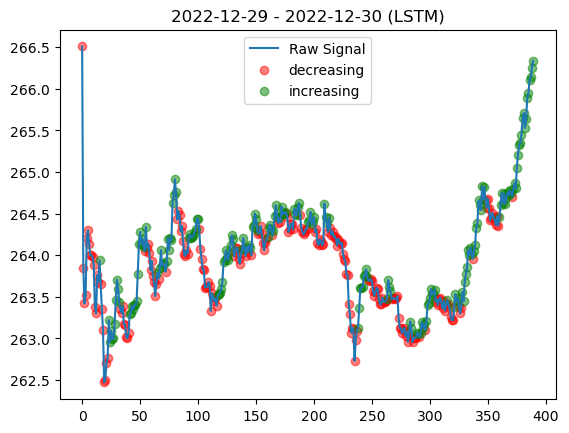

In [9]:
# build/train the LSTM
print('\nTraining LSTM:')
lstm = nn_train_driver.train_lstm(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# get the properly formatted test space
ytrue_test_lstm = test_df['Label']

# classify the test space/inverse onehot transform
yhat_test_lstm = nn_train_driver.inverse_onehot(lstm.predict(test_df[feature_cols]))

# print classification report
lstm_class_rep = classification_report(ytrue_test_lstm, yhat_test_lstm)
print(f'\nTest Space Classification Report (LSTM):\n{lstm_class_rep}')

# plot the LSTM classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test_lstm})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'LSTM')

### CNN


Training CNN:


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 14, 100)             │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │           2,802 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,402 (13.29 KB)

 Trainable params: 3,402 (13.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6489 - loss: 0.6402
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6782 - loss: 0.6039
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6780 - loss: 0.6039
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step

Test Space Classification Report (CNN):
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71     12448
         1.0       0.50      0.76      0.60      6345

    accuracy                           0.66     18793
   macro avg       0.67      0.69      0.66     18793
weighted avg       0.72      0.66      0.67     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

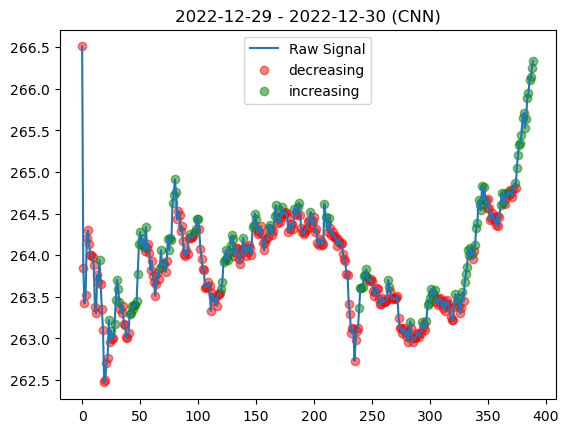

In [11]:
# build/train the CNN
print('\nTraining CNN:')
cnn = nn_train_driver.train_cnn(train_df, train_label_onehot, config=nn_config)

# get the appropriate columns to format the test df to just be the feature space
feature_cols = list(train_df.columns)
if 'EpochTime' in feature_cols:
    feature_cols.remove('EpochTime')
if 'Label' in feature_cols:
    feature_cols.remove('Label')

# get the properly formatted test space
ytrue_test_cnn = test_df['Label'].values
yhat_test_cnn = nn_train_driver.inverse_onehot(cnn.predict(test_df[feature_cols]))
cnn_class_rep = classification_report(yhat_test_cnn, ytrue_test_cnn)
print(f'\nTest Space Classification Report (CNN):\n{cnn_class_rep}')

# plot the CNN classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test_cnn})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'CNN')

In [12]:
# print confusion matrices for each model
print(f'MLP Confusion Matrix:\n{confusion_matrix(ytrue_test_mlp, yhat_test_mlp)}')
print(f'\n\nLSTM Confusion Matrix:\n{confusion_matrix(ytrue_test_lstm, yhat_test_lstm)}')
print(f'\n\nCNN Confusion Matrix:\n{confusion_matrix(ytrue_test_cnn, yhat_test_cnn)}')

MLP Confusion Matrix:
[[6038 3169]
 [2662 6924]]


LSTM Confusion Matrix:
[[6529 2678]
 [3152 6434]]


CNN Confusion Matrix:
[[7670 1537]
 [4778 4808]]


### ARIMA Assessment

#### Choosing ARIMA Order

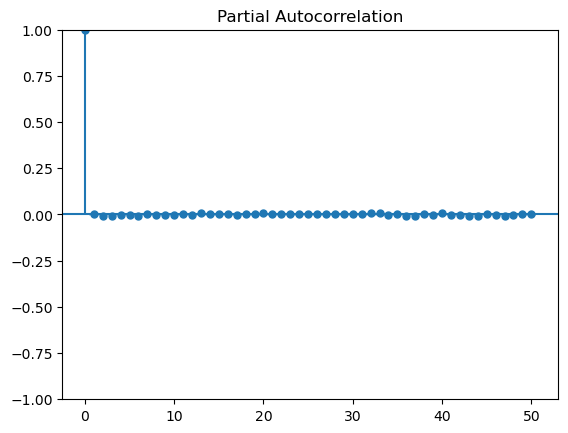

In [13]:
# The pacf and acf plots below are plotted twice due to an incompatability
# between the stats package and jupyter notebooks. Adding a semicolon to the
# end of the line solves the problem: https://github.com/statsmodels/statsmodels/issues/4155#issuecomment-445913264
plot_pacf(data_df[[sig_col]].diff().dropna());
p = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial autoregression param

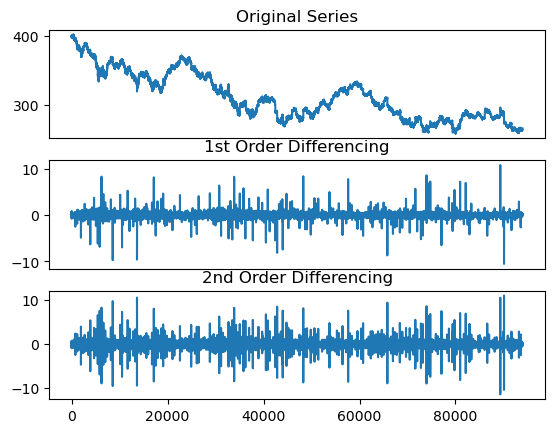

In [14]:
ps.plot_data_differencing(data_df, sig_col)
d = 1

Because the data appears relatively stabilized after a first order difference, we use that as the d param

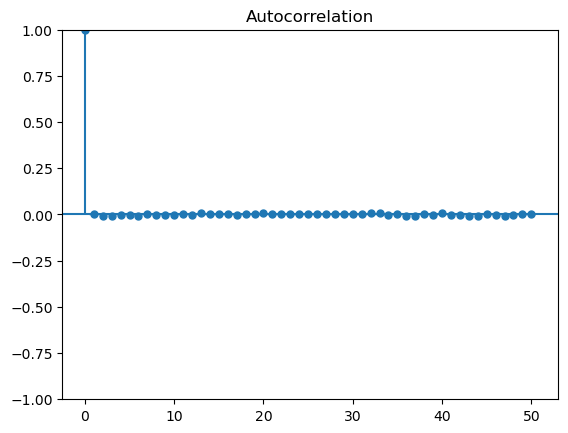

In [15]:
plot_acf(data_df[[sig_col]].diff().dropna());
q = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial moving average param

#### Evaluating ARIMA w/ Minute Forecasting

In [16]:
# filter data on the times from the test df above to cut down on run time.
# Running on the full "test_df" still takes about 15 mins
arima_minute_forecast_df = data_df.loc[np.in1d(data_df.EpochTime, test_df.EpochTime)]

# fit/forecast ARIMA
price_column = 'Close'
minute_forecast_df = arima.minute_forecast(arima_minute_forecast_df, sig_col=price_column)

100%|████████████████████████████████████████████████████████████████████████████| 18673/18673 [11:21<00:00, 27.42it/s]



ARIMA Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.59      0.58      9130
         1.0       0.60      0.59      0.59      9542

    accuracy                           0.59     18672
   macro avg       0.59      0.59      0.59     18672
weighted avg       0.59      0.59      0.59     18672



ARIMA Confusion Matrix:
[[5361 3769]
 [3911 5631]]


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

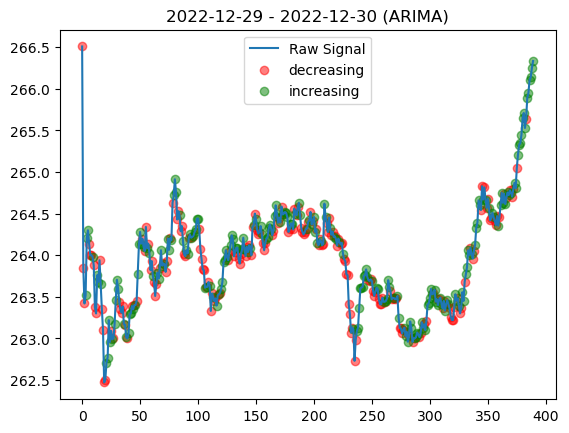

In [17]:
# classify the arima forecasts as increasing or decreasing
arima_yhat = arima.convert_forecast_to_classification(minute_forecast_df[f'Forecast {price_column}'].values)
arima_yhat_df = pd.DataFrame({'EpochTime': minute_forecast_df.EpochTime.iloc[-arima_yhat.shape[0]:],
                              'Label': arima_yhat})

# generate classification report
print(f'\nARIMA Classification Report:')
print(classification_report(test_df.Label.values[-arima_yhat.shape[0]:], 
                            arima_yhat))
print(f'\n\nARIMA Confusion Matrix:\n{confusion_matrix(test_df.Label.values[-arima_yhat.shape[0]:], arima_yhat)}')

# plot the ARIMA diff overtop the raw prices for the final day (390 minutes) in the DF
ps.plot_label_over_signal(data_df.iloc[-390:], arima_yhat_df.iloc[-390:], 'Close', model_type='ARIMA')

#### Evaluating ARIMA w/ Daily Forecasting

In [ ]:
# adjusts the index of the data to a date-timestamp using the epoch time column
date_indexed_df = arima.index_df_by_date(data_df)

# extract the true day values for ARIMA evaluation
true_values = arima.get_arima_true_values(date_indexed_df, sig_col)

# fit the model with the p,d,q variables and forecast the next data point
forecast_df = arima.day_forecast(date_indexed_df, sig_col, p, d, q)

# merge the actual and forecast data together on the day
arima_df = pd.merge(true_values, forecast_df, left_index=True, right_index=True)
arima_df = arima_df.rename(columns={1: forecast_sig_col})

# plot the actual vs forecast values
ps.plot_forecast(arima_df, sig_col, forecast_sig_col, 10)